In [1]:
import pickle
import pandas as pd
import numpy as np

from keras import backend as K
import nltk

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, SpatialDropout1D, concatenate
from keras.layers import Bidirectional, GlobalMaxPooling1D, CuDNNGRU
from keras.layers import GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.models import Model
from keras.layers.convolutional import Conv1D

import matplotlib.pyplot as plt

cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))
%matplotlib inline

Using TensorFlow backend.


In [2]:
import logging
from sklearn.metrics import roc_auc_score, f1_score
from keras.callbacks import Callback

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("- ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

class F1Evaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = f1_score(self.y_val, np.where(y_pred >= 0.5, 1, 0), average='micro')
            print("- F1-micro (0.5 threshold) - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [3]:
BASE_DIR = '../data/'
EMBEDDING_FILE = "C:/edx/competition/data/vectors.kv"
TRAIN_DATA_FILE = BASE_DIR + 'train_preprocessed.pkl'
TEST_DATA_FILE = BASE_DIR + 'test_preprocessed.pkl'
LABEL_FILE = BASE_DIR + 'labels_preprocessed.pkl'
MAX_WORDS = 200000
MAX_SEQUENCE_LENGTH = 2000 #just a bit above mean average word count for TRAIN

In [4]:
train = pickle.load(open(TRAIN_DATA_FILE,'rb'))
test = pickle.load(open(TEST_DATA_FILE,'rb'))
#labels = pd.read_csv(LABEL_FILE, index_col = 'row_id')
labels = pickle.load(open(LABEL_FILE, 'rb'))
label_cols = [x for x in labels.columns]
#labels = np.array(labels.values, dtype=np.uint8)
sub = pd.read_csv('../data/submission_format.csv')
sub[:] = -1

In [5]:
tokenizer = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(list(train.doc_text.values) + list(test.doc_text.values))
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= MAX_WORDS}
sequence_train = tokenizer.texts_to_sequences(list(train.doc_text.values))
sequence_test = tokenizer.texts_to_sequences(list(test.doc_text.values))

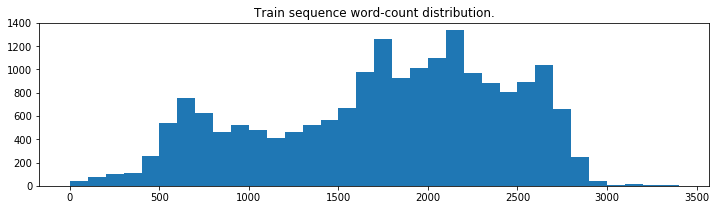

Average word count in train: 1761.4052343209746


In [6]:
totalNumWords = [len(one_comment) for one_comment in sequence_train]
plt.figure(figsize=(12,3))
plt.hist(totalNumWords,bins = np.arange(0,3500,100))
plt.title('Train sequence word-count distribution.')
plt.show()
print("Average word count in train:", np.mean(totalNumWords))

In [7]:
train_data = pad_sequences(sequence_train, maxlen = MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(sequence_test, maxlen = MAX_SEQUENCE_LENGTH)

In [8]:
## Preparing the Word2Vec embedding matrix
#NOTE: this model is custom-built, with an embedding size of 200
print('Loading pre-trained Word2Vec model (large, be patient)!')

from gensim.test.utils import get_tmpfile
fname = get_tmpfile(EMBEDDING_FILE)
word2vec = KeyedVectors.load(fname, mmap='r')
print('Found %d word vectors in word2vec pre-trained model!' % len(word2vec.vocab))

nb_words = min(MAX_WORDS, len(tokenizer.word_index)) + 1
embedding_matrix = np.zeros((nb_words, 200))
missing_words = []
for word, i in tokenizer.word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
    else:
        missing_words.append(word)

print('Total word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) != 0))
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Loading pre-trained Word2Vec model (large, be patient)!
Found 170483 word vectors in word2vec pre-trained model!
Total word embeddings: 170483
Null word embeddings: 29518


In [9]:
#create fixed, non-trainable Embedding layer
embedding_layer = Embedding(nb_words,
    200,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False)

In [10]:
#model architecture
inp = Input(shape=(MAX_SEQUENCE_LENGTH, ))
x = embedding_layer(inp)
x = SpatialDropout1D(0.1)(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
x = Conv1D(64, kernel_size = 2, padding = 'valid', kernel_initializer = 'he_uniform')(x)
max_pool = GlobalMaxPooling1D()(x)
avg_pool = GlobalAveragePooling1D()(x)
x = concatenate([avg_pool, max_pool])
#x = Dense(32, activation='relu')(x)
x = Dense(len(labels.columns), activation='sigmoid')(x)

batch_size = 128
epochs = 25

for label in label_cols:
    print('... Processing "{}".\n------------------------------\n'.format(label))
    y = labels[label].values
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr = 1e-3), metrics=['accuracy'])
    model.fit(train_data, labels[label], batch_size=batch_size, epochs=epochs)
    sub[label] = model.predict(test_data)
    print('\tPredictions written to sub!.\n')

print('Predictions complete - check the "sub" variable.')
print('NOTE: need to evaluate thresholds - have to be converted to 1 / 0')

In [11]:
#sub[label_cols] = np.where(sub.values >= 0.5, 1, 0)
#sub.head()

In [12]:
#sub.to_csv('../data/submission_troi_one-at-a-time.csv')

In [13]:
batch_size = 128
epochs = 25
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr = 1e-3), metrics=['accuracy'])  
model.fit(train_data, labels, batch_size=batch_size, epochs=epochs)

Epoch 1/25
18799/18799 [==============================] - 81s 4ms/step - loss: 0.2908 - acc: 0.8937
Epoch 2/25
18799/18799 [==============================] - 79s 4ms/step - loss: 0.2282 - acc: 0.9155
Epoch 3/25
18799/18799 [==============================] - 79s 4ms/step - loss: 0.2116 - acc: 0.9209
Epoch 4/25
18799/18799 [==============================] - 79s 4ms/step - loss: 0.2027 - acc: 0.9237
Epoch 5/25
18799/18799 [==============================] - 79s 4ms/step - loss: 0.1961 - acc: 0.9258
Epoch 6/25
18799/18799 [==============================] - 79s 4ms/step - loss: 0.1907 - acc: 0.9274
Epoch 7/25
18799/18799 [==============================] - 79s 4ms/step - loss: 0.1857 - acc: 0.9292
Epoch 8/25
18799/18799 [==============================] - 79s 4ms/step - loss: 0.1814 - acc: 0.9307
Epoch 9/25
18799/18799 [==============================] - 79s 4ms/step - loss: 0.1769 - acc: 0.9322
Epoch 10/25
18799/18799 [==============================] - 79s 4ms/step - loss: 0.1729 - acc: 0.9335

In [14]:
out = model.predict(test_data)

In [15]:
sub = test.copy()
sub.drop(columns=['doc_text'], inplace=True)
for _col in labels:
    sub[_col] = np.uint8(0)

In [16]:
sub[:] = np.where(out >= 0.5, 1, 0)

In [17]:
test_pre_pred = pickle.load(open('../data/test_predicted.pkl','rb'))
sub = pd.concat([sub,test_pre_pred]).sort_values(by='row_id')

In [18]:
print(sub.shape)
sub.head(10)

(18831, 29)


,information_and_communication_technologies,governance,urban_development,law_and_development,public_sector_development,agriculture,communities_and_human_settlements,health_and_nutrition_and_population,culture_and_development,environment,...,private_sector_development,informatics,energy,social_development,water_resources,education,transport,water_supply_and_sanitation,gender,infrastructure_economics_and_finance
row_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
sub.to_csv('../submissions/sub_try.csv')